In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
from sklearn.model_selection import train_test_split

In [2]:
def Create_Generator():
    gen = tf.keras.Sequential()
    gen.add(tf.keras.layers.Dense(8*8*384, use_bias = False, input_shape=(100,)))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    gen.add(tf.keras.layers.Reshape((8,8,384)))
    gen.add(tf.keras.layers.Conv2DTranspose(192, (5,5), strides=(1,1), padding='same', use_bias = False))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    gen.add(tf.keras.layers.Conv2DTranspose(96, (5,5), strides=(2,2), padding='same', use_bias = False))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    gen.add(tf.keras.layers.Conv2DTranspose(48, (5,5), strides=(2,2), padding='same', use_bias = False))
    gen.add(tf.keras.layers.BatchNormalization())
    gen.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    gen.add(tf.keras.layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias = False, activation='tanh'))
    return gen

In [3]:
def Create_Discriminator():
    dis = tf.keras.Sequential()
    
    dis.add(tf.keras.layers.Conv2D(96, (5,5), strides=(2,2), padding='same'))
    dis.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    dis.add(tf.keras.layers.Dropout(0.3))
    
    dis.add(tf.keras.layers.Conv2D(192, (5,5), strides=(2,2), padding='same'))
    dis.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    dis.add(tf.keras.layers.Dropout(0.3))
    
    dis.add(tf.keras.layers.Flatten())
    dis.add(tf.keras.layers.Dense(1))
    return dis

In [4]:
def make_trainable(dis, flag):
    dis.trainable = flag
    for l in dis.layers:
        l.trainable = flag
    return dis

In [5]:
def make_noise(n, z):
    return np.random.normal(0, 1, size=(n,z))

In [6]:
def plot_sample(n,z,Generator, index):
    print("Samples:")
    samples = Generator.predict(make_noise(n,z))
    samples = (samples + 1.0) / 2.0
    plt.figure(figsize=(4,4))
    for i in range(n):
        plt.subplot(4,4, (i+1))
        plt.imshow(samples[i].reshape(64,64,3))
        plt.axis('off')
    plt.savefig("GAN_" + str(index) + "_Epochs_Samples",
               bbox_inches='tight',
               pad_inches = 0,
               transparent = False,
               dpi =400)
    plt.show()

In [7]:
def LoadAndDecodeImage(imagePath): 
    rawImageData = tf.io.read_file(imagePath)
    imageData = tf.io.decode_jpeg(rawImageData, channels = 3)
    imageData = tf.image.convert_image_dtype(imageData, tf.float32)
    imageData = tf.image.resize(imageData, (64, 64))
    return imageData

In [8]:
def processPath(imagePath):
    return LoadAndDecodeImage(imagePath)

In [9]:
def generator_loss(generated_output):
    return tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(generated_output), logits = generated_output)

In [10]:
def discriminator_loss(real_output, generated_output):
    real = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(real_output), logits = real_output)
    generated = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(generated_output), logits = generated_output)
    total_loss = real + generated
    return total_loss

In [11]:
def main():

    path = os.getcwd() + "/img_align_celeba/" 
    dir_list = os.listdir(path)
    for i in range(len(dir_list)):
        dir_list[i] = path + dir_list[i]
    
    ds_file_path = np.array(dir_list)
    trainFiles, _ = train_test_split(ds_file_path, train_size=0.8, random_state=42)
    DS = tf.data.Dataset.from_tensor_slices(trainFiles)
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_ds = DS.map(LoadAndDecodeImage, num_parallel_calls=AUTOTUNE)
    
    train_np = tfds.as_numpy(train_ds)
    
    train_list = []
    
    for images in train_np:
        train_list.append(images)
    
    X_train = np.array(train_list)
    
    epochs = 100
    batch_size = 32
    input_dim = 100
    
    Generator = Create_Generator()
    Discriminator = Create_Discriminator()
    
    generator_optimizer = tf.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.optimizers.Adam(1e-4)
    batch_no = int(len(X_train)/batch_size)
    
    np.random.seed(42)
    
    for i in range(0, epochs):
        for j in range(batch_no):
            
            rand_sample = np.random.randint(0, len(X_train), size=batch_size)
           
            image_batch = X_train[rand_sample]
            
            input_noise = make_noise(batch_size, input_dim)
            
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                
                generated_images = Generator(input_noise, training=True)
                real_output = Discriminator(image_batch, training=True)
                generated_output = Discriminator(generated_images, training=True)

                Generator_Loss = generator_loss(generated_output)
                Discriminator_Loss = discriminator_loss(real_output, generated_output)
    
            
            gradient_of_generator = gen_tape.gradient(Generator_Loss, Generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradient_of_generator, Generator.trainable_variables))
            
            gradient_of_discriminator = disc_tape.gradient(Discriminator_Loss, Discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, Discriminator.trainable_variables))
            
        if i % 10 == 0:
            print("Epoch %i" % i)
            plot_sample(16, input_dim, Generator, i)
    
    tf.keras.models.save_model(Generator, '.h5', include_optimizer=True)

Epoch 0
Samples:
1/1 [==============================] - 0s 250ms/step


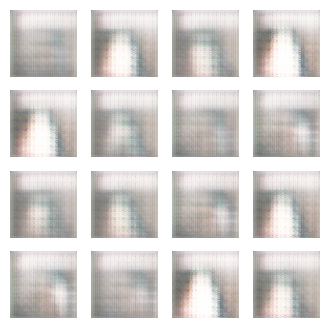

Epoch 10
Samples:
1/1 [==============================] - 0s 32ms/step


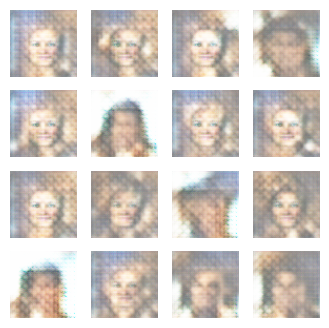

Epoch 20
Samples:
1/1 [==============================] - 0s 35ms/step


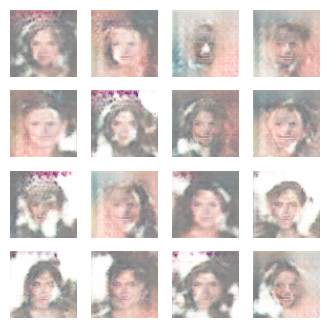

Epoch 30
Samples:
1/1 [==============================] - 0s 28ms/step


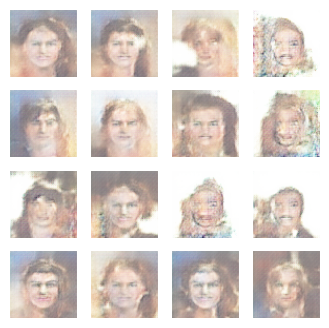

Epoch 40
Samples:
1/1 [==============================] - 0s 29ms/step


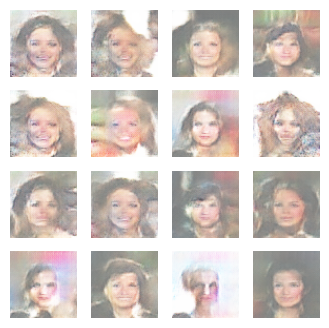

Epoch 50
Samples:
1/1 [==============================] - 0s 34ms/step


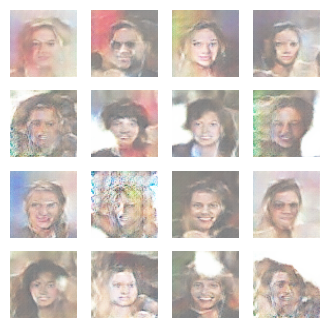

Epoch 60
Samples:
1/1 [==============================] - 0s 27ms/step


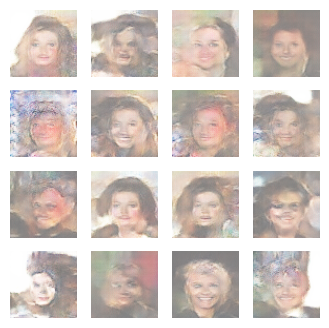

Epoch 70
Samples:
1/1 [==============================] - 0s 31ms/step


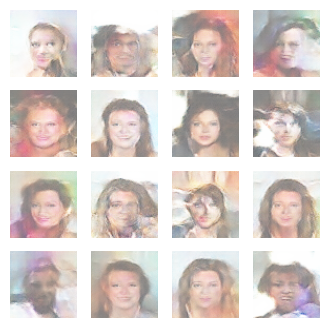

Epoch 80
Samples:
1/1 [==============================] - 0s 34ms/step


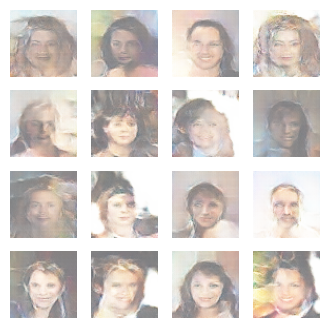

Epoch 90
Samples:
1/1 [==============================] - 0s 28ms/step


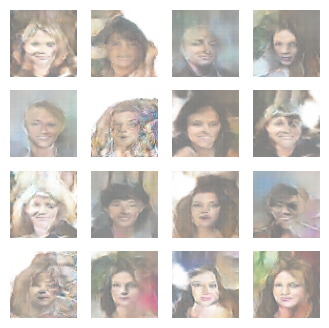

In [12]:
if __name__ == '__main__':
    main()